In [1]:
import os

In [2]:
# clean last run result

!('./clean.sh')

/bin/bash: line 1: ./clean.sh: Permission denied


In [3]:
# add the package to import path

import sys 
sys.path.append("../../")

In [4]:
from thunder_ase.fireball import Fireball, MultiFireball
import ase
from ase.io.trajectory import Trajectory
import numpy as np
from ase.io import read
from ase.units import kJ
from ase.eos import EquationOfState

### parameters for Si crystal

In [5]:
cell = np.array([[2.715000, 2.715000, 0.000000],
                 [2.715000, 0.000000, 2.715000],
                 [0.000000, 2.715000, 2.715000]])
positions = np.array([[0.0000000, 0.0000000, 0.0000000],
                      [1.3575000, 1.3575000, 1.3575000]])

### parameters for fireball

In [11]:
# set Fdata dir
Fdata_path='/home/faustival/thunder-dft/fdata/Fdata-McWEDA-0.15-3SN.Sis4.8p5.35'

In [12]:
kwargs = {'kpt_size': [2, 2, 2],
          'iwriteout_ME_SandH': 0,
          'iwriteout_density': 0,
          'iwriteout_cdcoeffs': 0,
          'iwriteout_charges': 1,
          'iwriteout_energies': 0,
          'iwriteout_populations': 0,
          'iwriteout_forces': 1,
          'iwriteout_neighbors': 0,
          'iwriteout_dos': 0,
          'iwriteout_abs': 0,
          'iwriteout_ewf': 0,
          'nstepi': 1,
          'nstepf': 100,
          'iquench': -3,
          'T_initial': 0.0,
          'T_final': 0.0,
          'T_want': 0.0,
          'taurelax': 5.0,
          'efermi_T': 200.0,
          'dt': 1.00,
          'iensemble': 0,
          'iconstraint_rcm': 1,
          'iconstraint_vcm': 1,
          'iconstraint_L': 0,
          'iconstraint_KE': 1,
          'ifix_neighbors': 0,
          'ifix_CHARGES': 0,
          'max_scf_iterations_set': 100,
          'scf_tolerance_set': 0.00000001,
          'beta_set': 0.04,
          'Ecut_set': 200.0,
          'rho_surface_min': 0.0005,
          'rho_surface_max': 0.01000000,
          }

In [13]:
# scale the cell from 0.8 to 1.2
cell_factors = np.linspace(0.8, 1.2, 8)

## Run Fireball

There are two way to run fireball calculator

* serial mode by Fireball calculator
* multi-atoms mode by MultiFireball calculator

We recommend multi-atoms mode, which saves Fdata reading time.

### 1. Run fireball in series mode

In [14]:
# save the trajectory during calculation

traj = Trajectory('Si.traj', 'w')

# main loop, will takes several minutes

for cf in cell_factors:
    atoms = ase.Atoms(numbers=[14, 14],
                      cell=cell,
                      pbc=True,
                      positions=positions,
                      )
    atoms.set_cell(cell=cell*cf, scale_atoms=True)
    calc = Fireball(command='/home/faustival/bin/lightning_McWEDA.x', 
                    Fdata_path=Fdata_path,
                    **kwargs)
    atoms.set_calculator(calc)
    e0 = atoms.get_potential_energy()
    traj.write(atoms)
    print("The energy for cell factor {:.3f} is {:.3f}".format(cf, e0))

  LIGHTNING RUNTIME :   0.603281000000000      [sec] 
The energy for cell factor 0.800 is -202.987
  LIGHTNING RUNTIME :   0.236469000000000      [sec] 
The energy for cell factor 0.857 is -208.122
  LIGHTNING RUNTIME :   0.237512000000000      [sec] 
The energy for cell factor 0.914 is -211.120
  LIGHTNING RUNTIME :   0.189553000000000      [sec] 
The energy for cell factor 0.971 is -212.631
  LIGHTNING RUNTIME :   0.181920000000000      [sec] 
The energy for cell factor 1.029 is -213.045
  LIGHTNING RUNTIME :   0.170601000000000      [sec] 
The energy for cell factor 1.086 is -212.732
  LIGHTNING RUNTIME :   0.155120000000000      [sec] 
The energy for cell factor 1.143 is -212.124
  LIGHTNING RUNTIME :   0.141012000000000      [sec] 
The energy for cell factor 1.200 is -211.223


<AxesSubplot: title={'center': 'sj: E: -213.022 eV, V: 44.376 Å$^3$, B: 82.690 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

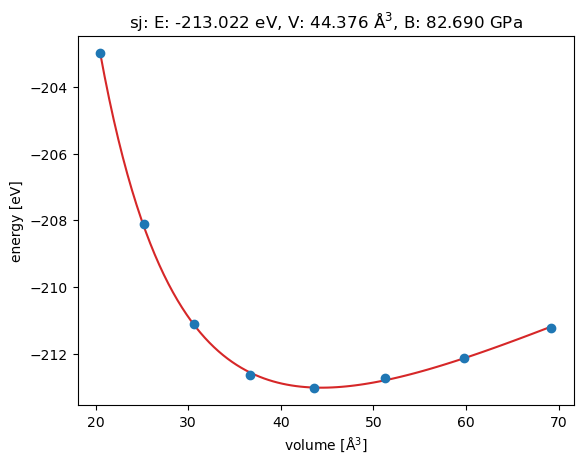

In [15]:
# read the atoms
configs = read('Si.traj', index=':')
volumes = [si.get_volume() for si in configs]
energies = [si.get_potential_energy() for si in configs]
# fit Equation of State
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
# plot result
eos.plot()

### 2. Run fireball in multi-atoms mode

In [18]:
atoms_list = []

for cf in cell_factors:
    atoms = ase.Atoms(numbers=[14, 14],
                      cell=cell,
                      pbc=True,
                      positions=positions,
                      )
    atoms.set_cell(cell=cell*cf, scale_atoms=True)
    calc = Fireball(command='/home/faustival/bin/lightning_McWEDA.x', 
                    Fdata_path=Fdata_path,
                    **kwargs)
    atoms.set_calculator(calc)
    atoms_list.append(atoms)

# set up multi-fireball calculator

multi_calc = MultiFireball(atoms_list=atoms_list)
multi_calc.write_input()
multi_calc.calculate()

# save the trajectory during calculation

traj = Trajectory('Si_multicalc.traj', 'w')
_ = [traj.write(atoms)  for atoms in atoms_list]

# print e0
e0_list = [atoms.get_potential_energy() for atoms in atoms_list]
for cf, e0 in zip(cell_factors, e0_list):
    print("The energy for cell factor {:.3f} is {:.3f}".format(cf, e0)) 

  LIGHTNING RUNTIME :    1.60508600000000      [sec] 
The energy for cell factor 0.800 is -202.987
The energy for cell factor 0.857 is -208.122
The energy for cell factor 0.914 is -211.120
The energy for cell factor 0.971 is -212.631
The energy for cell factor 1.029 is -213.045
The energy for cell factor 1.086 is -212.732
The energy for cell factor 1.143 is -212.124
The energy for cell factor 1.200 is -211.223


<AxesSubplot: title={'center': 'sj: E: -213.022 eV, V: 44.376 Å$^3$, B: 82.691 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

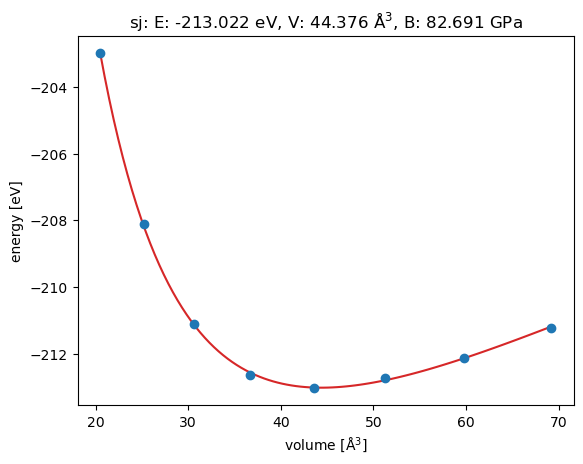

In [19]:
# read the atoms
configs = read('Si_multicalc.traj', index=':')
volumes = [si.get_volume() for si in configs]
energies = [si.get_potential_energy() for si in configs]
# fit Equation of State
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
# plot result
eos.plot()